In [1]:
################################
# Scientific imports
################################
import gc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import fnmatch

from astropy.io import fits
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astroquery.mast import Observations
from astroquery.mast import Catalogs

from scipy.signal import butter,filtfilt,sosfilt

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

################################
# SciKitLearn Imports
################################
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from IPython.display import display

################################
# MatPlotLib Settings
################################
#plt.rcParams["figure.figsize"] = (16,5)
sb.set()

################################
# Initialisers
################################

fitsarr = np.load("fitslist.npy")
masterX = np.load("True_NOO_fluxes.npy")
masterY = np.load("True_NOO_isplanetlist.npy")

xNaNs = np.load("X_NAN_LIST.npy")
xTime = np.load("X_TIME_LIST.npy")

In [55]:
################################
# FUNCTIONS
################################

def DrawLC(rndFile=-1):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
        
    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"

    #ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)
    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)

################################

def FilterMyData(x,cutoff=0.00005,order=2,xNaNs=xNaNs):
    
    """
    Function to apply a Butter Filter to timeseries.
    Vars:
    
    y:        The timeseries. Must be list or np array.
    cutoff:   The cutoff frequency. Used to determine where the filter cut off is.
    order:    Approximation via polynomial of the order'th degree (2=quadratic, 3=cubic, 4=quartic, etc)
    """
    
    # First, let's calculate the observational time period;
    # This is done separately so that I can change this in the future for any TESS fits file
    numdays       = GetNumDays()
    
    # Next, fix data                           
    xMedian       = np.median(x)                                                    
    x             = [xMedian if n in xNaNs else item for n,item in enumerate(x)]    
    
    # Frequency Data Stuff
    sec           = numdays*24*60*60   # Number of seconds in the overall observation period
    freq          = len(x)/sec         # Frequency, in Hz, ie number of observations per second
    # FREQ IS APPROX 1/120 OR ~0.008333333
    
    # Butter Lowpass Filter
    #polynomOrder  = order
    nyq           = 0.5 * freq
    normal_cutoff = cutoff / nyq
    #b, a          = butter(polynomOrder, normal_cutoff, btype='low', analog=False)
    b, a          = butter(order, normal_cutoff, btype='low', analog=False)
    newX          = filtfilt(b, a, x)
    
    # Finally, return the new X and Y values
    return (newX)

################################################################

def SOSFilterMyData(x,cutoff=0.00005,order=2,xNaNs=xNaNs):
    
    """
    Function to apply a Butter Filter to timeseries.
    Vars:
    
    y:        The timeseries. Must be list or np array.
    cutoff:   The cutoff frequency. Used to determine where the filter cut off is.
    order:    Approximation via polynomial of the order'th degree (2=quadratic, 3=cubic, 4=quartic, etc)
    """
    
    # First, let's calculate the observational time period;
    # This is done separately so that I can change this in the future for any TESS fits file
    numdays       = GetNumDays()
    
    # Next, fix data                           
    xMedian       = np.median(x)                                                    
    x             = [xMedian if n in xNaNs else item for n,item in enumerate(x)]    
    
    # Frequency Data Stuff
    sec           = numdays*24*60*60   # Number of seconds in the overall observation period
    freq          = len(x)/sec         # Frequency, in Hz, ie number of observations per second
    # FREQ IS APPROX 1/120 OR ~0.008333333
    
    # Butter Lowpass Filter
    #polynomOrder  = order
    nyq           = 0.5 * freq
    normal_cutoff = cutoff / nyq
    #b, a          = butter(polynomOrder, normal_cutoff, btype='low', analog=False)
    sos           = butter(order, normal_cutoff, btype='hp', analog=False, output='sos')
    newX          = sosfilt(sos, x)
    
    # Finally, return the new X and Y values
    return (newX)

################################

def GetNumDays(time=xTime):
    
    #xTime = np.load("X_TIME_LIST.npy")
    nDays = time[-1]-time[0]
    
    return (nDays)

################################

def Every_Nth_Value(y,nth=40):
    return (y[::nth])

################################

def FIXNAN(X,xNaNs=xNaNs):
    
    xMedian = np.median(X)                                                    
    x       = [xMedian if n in xNaNs else item for n,item in enumerate(X)]
    
    return (x)
    
################################

def FTTMyData(y,norm=None):
    """
    Function that takes in a timeseries and then outputs a Fourier Transformed version of it
    """
    
    # FOURIER TRANSFORM THAT Y (remember to use np.nanmean instead of np.mean)
    FTY = np.fft.fft(y-np.mean(y),norm=norm)
    powSpectrum = np.abs(FTY)
    
    #plt.plot(F,powSpectrum)
    return(powSpectrum)

################################

def Normal(masterX):
    
    #print("Step 2: Normalise")
    
    # Takes in 'masterX', my 9154 long array of LCs.
    # Need to return a 9154 array, where the daya has been normalised for EACH LC
    for X in masterX:
        median = np.median(X)
        X[:] = np.asarray([(number/median) for number in X])
    
    return masterX

################################################################

def NormalSingle(X):
    
    #print("Step 2: Normalise")
    
    # Takes in 'masterX', my 9154 long array of LCs.
    # Need to return a 9154 array, where the daya has been normalised for EACH LC
    median = np.median(X)
    X[:] = np.asarray([(number/median) for number in X])
    
    return X

################################

def FIXNAN(masterX, nanList=xNaNs):
    
    #print("Step 1: Fix NaN")
    
    # Takes in 'masterX', my 9154 long array of LCs.
    # Need to return a 9154 array, where the daya has been normalised for EACH LC
    for X in masterX:
        #print(f"\t> Length of X is {len(X)}")
        XMedian = np.median(X)
        X[:]= np.asarray([XMedian if n in nanList else item for n,item in enumerate(X)])
    
    return masterX

################################

################################

## Two Sample Light Curves

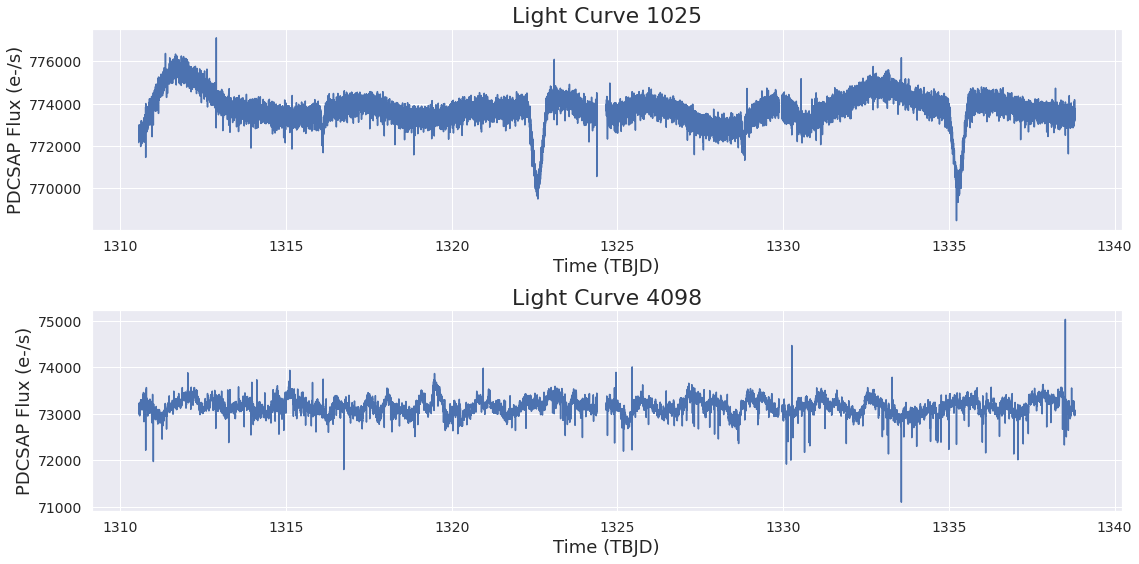

In [3]:
plt.rcParams["figure.figsize"] = (16,8)

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.35)

n1 = 1025
n2 = 4098
x1,y1,f1,_,_, ylab1, xlab1 = DrawLC(n1)
x2,y2,f2,_,_, ylab2, xlab2 = DrawLC(n2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.plot(x1,y1)
ax1.set_xlabel(xlab1, fontsize=18)
ax1.set_ylabel(ylab1, fontsize=18)
ax1.set_title(f"Light Curve {n1}", fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(x2,y2)
ax2.set_xlabel(xlab2, fontsize=18)
ax2.set_ylabel(ylab2, fontsize=18)
ax2.set_title(f"Light Curve {n2}", fontsize=22)

ax2.tick_params(axis='both', which='major', labelsize=14)

#cxy, f = ax2.csd(s1, s2, 256, 1. / dt)
#ax2.set_ylabel('CSD (db)')
plt.tight_layout()
plt.savefig("./img/lc-scales-new-before.png")
plt.show()

## Same Curves, Normalised

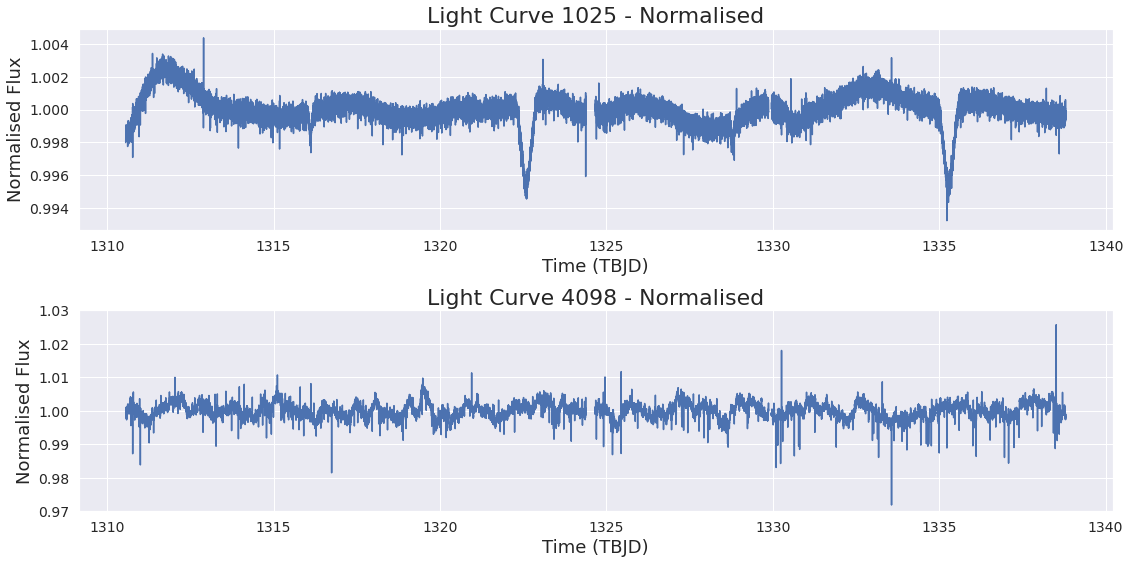

In [7]:
plt.rcParams["figure.figsize"] = (16,8)

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.35)

y1_med = np.nanmedian(y1)
y2_med = np.nanmedian(y2)

y1_norm = [y/y1_med for y in y1]
y2_norm = [y/y2_med for y in y2]

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.plot(x1,y1_norm)
ax1.set_xlabel(xlab1, fontsize=18)
ax1.set_ylabel("Normalised Flux", fontsize=18)
ax1.set_title(f"Light Curve {n1} - Normalised", fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(x2,y2_norm)
ax2.set_xlabel(xlab2, fontsize=18)
ax2.set_ylabel("Normalised Flux", fontsize=18)
ax2.set_title(f"Light Curve {n2} - Normalised", fontsize=22)

ax2.set_ylim([0.97,1.03])

ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("./img/lc-scales-new-normalised.png")
plt.show()

## Same Curves, Normalised and Filtered

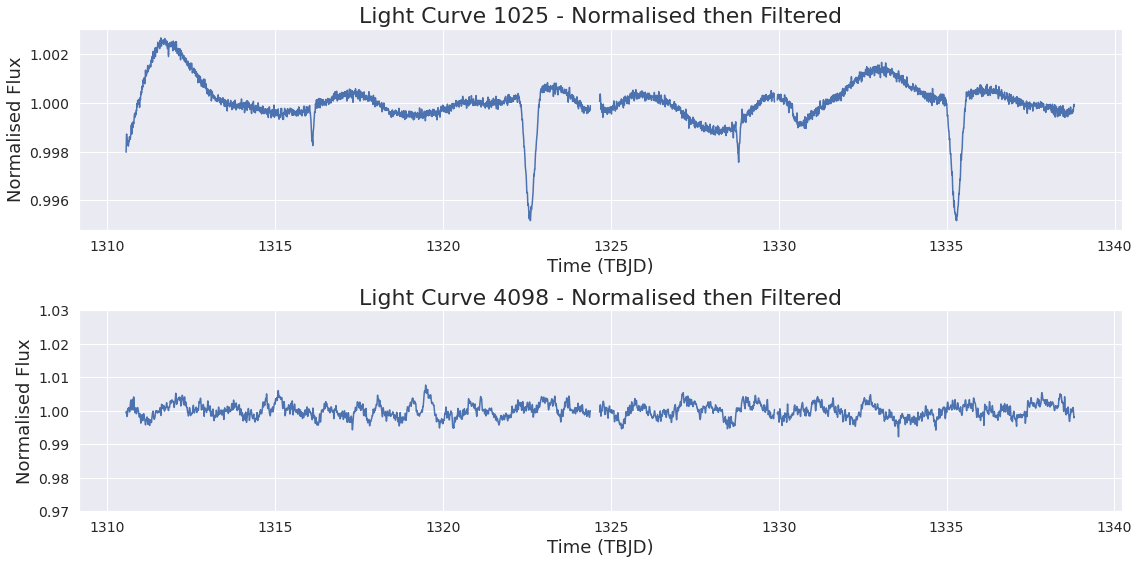

In [8]:
plt.rcParams["figure.figsize"] = (16,8)

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.35)

y1_filt = FilterMyData(y1_norm,5e-04)
y2_filt = FilterMyData(y2_norm,5e-04)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.plot(x1,y1_filt)
ax1.set_xlabel(xlab1, fontsize=18)
ax1.set_ylabel("Normalised Flux", fontsize=18)
ax1.set_title(f"Light Curve {n1} - Normalised then Filtered", fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(x2,y2_filt)
ax2.set_xlabel(xlab2, fontsize=18)
ax2.set_ylabel("Normalised Flux", fontsize=18)
ax2.set_title(f"Light Curve {n2} - Normalised then Filtered", fontsize=22)

ax2.set_ylim([0.97,1.03])

ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("./img/lc-scales-new-filtered.png")
plt.show()

## Same Curves, Normalised then Filtered then Sub-sampled

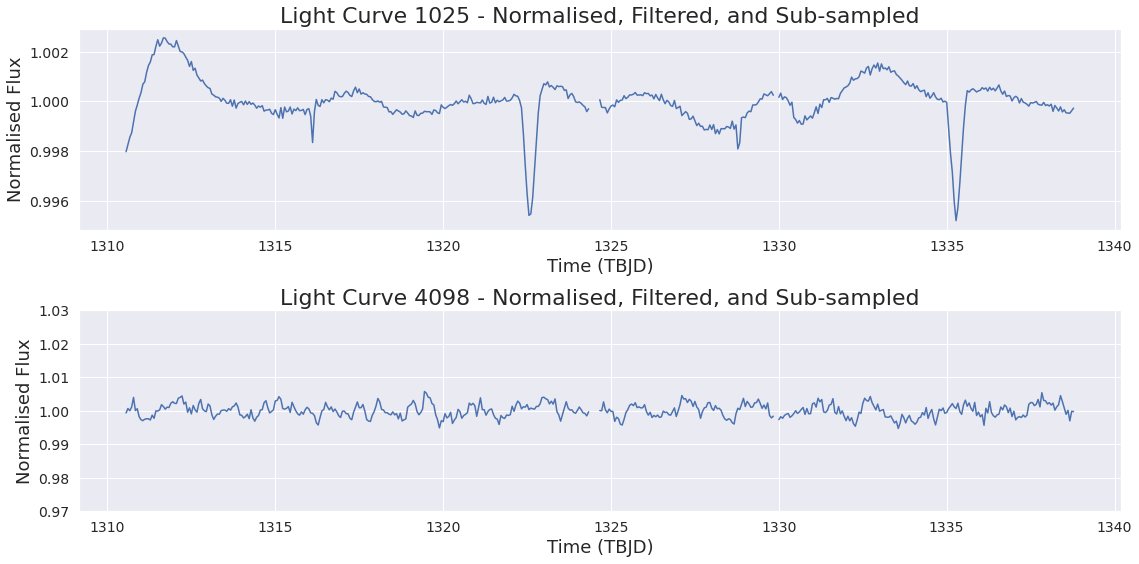

In [9]:
plt.rcParams["figure.figsize"] = (16,8)

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.35)

filt_num = 40

x1_sub = Every_Nth_Value(x1,filt_num)
x2_sub = Every_Nth_Value(x2,filt_num)

y1_sub = Every_Nth_Value(y1_filt,filt_num)
y2_sub = Every_Nth_Value(y2_filt,filt_num)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.plot(x1_sub,y1_sub)
ax1.set_xlabel(xlab1, fontsize=18)
ax1.set_ylabel("Normalised Flux", fontsize=18)
ax1.set_title(f"Light Curve {n1} - Normalised, Filtered, and Sub-sampled", fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(x2_sub,y2_sub)
ax2.set_xlabel(xlab2, fontsize=18)
ax2.set_ylabel("Normalised Flux", fontsize=18)
ax2.set_title(f"Light Curve {n2} - Normalised, Filtered, and Sub-sampled", fontsize=22)

ax2.set_ylim([0.97,1.03])

ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("./img/lc-scales-new-subsampled.png")
plt.show()

## Transformed Curves overlain onto Normalised Raw Data

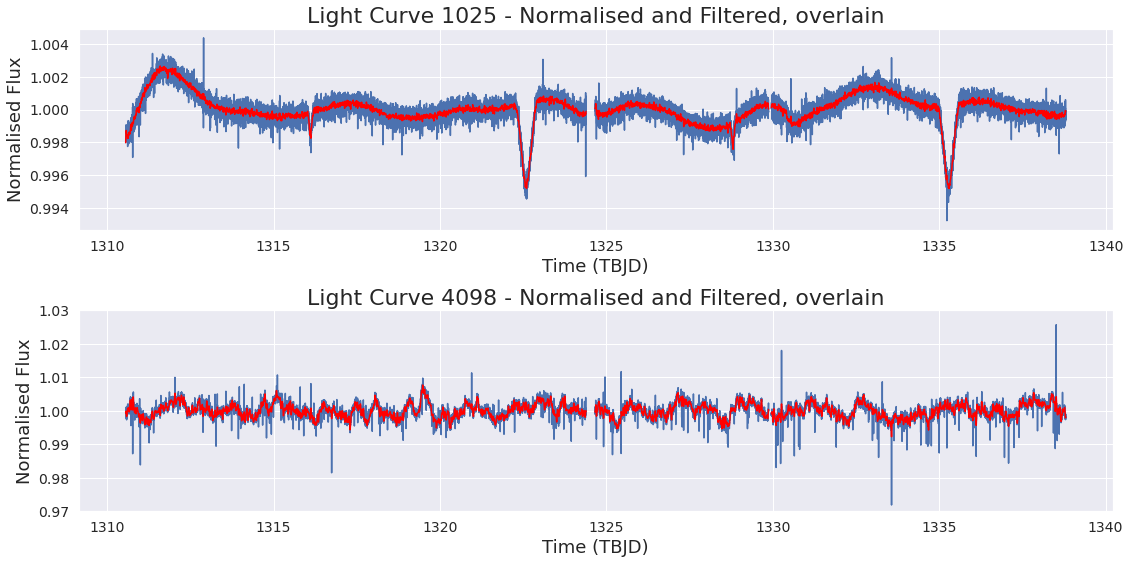

In [10]:
plt.rcParams["figure.figsize"] = (16,8)
fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.35)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.plot(x1,y1_norm)
ax1.plot(x1,y1_filt,'#ff0000')
ax1.set_xlabel(xlab1, fontsize=18)
ax1.set_ylabel("Normalised Flux", fontsize=18)
ax1.set_title(f"Light Curve {n1} - Normalised and Filtered, overlain", fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(x2,y2_norm)
ax2.plot(x2,y2_filt,'#ff0000')
ax2.set_xlabel(xlab2, fontsize=18)
ax2.set_ylabel("Normalised Flux", fontsize=18)
ax2.set_title(f"Light Curve {n2} - Normalised and Filtered, overlain", fontsize=22)

ax2.set_ylim([0.97,1.03])

ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("./img/lc-scales-new-filter-overlay.png")
plt.show()

## Norm/Filt/Subsampled overlain onto Raw Curves

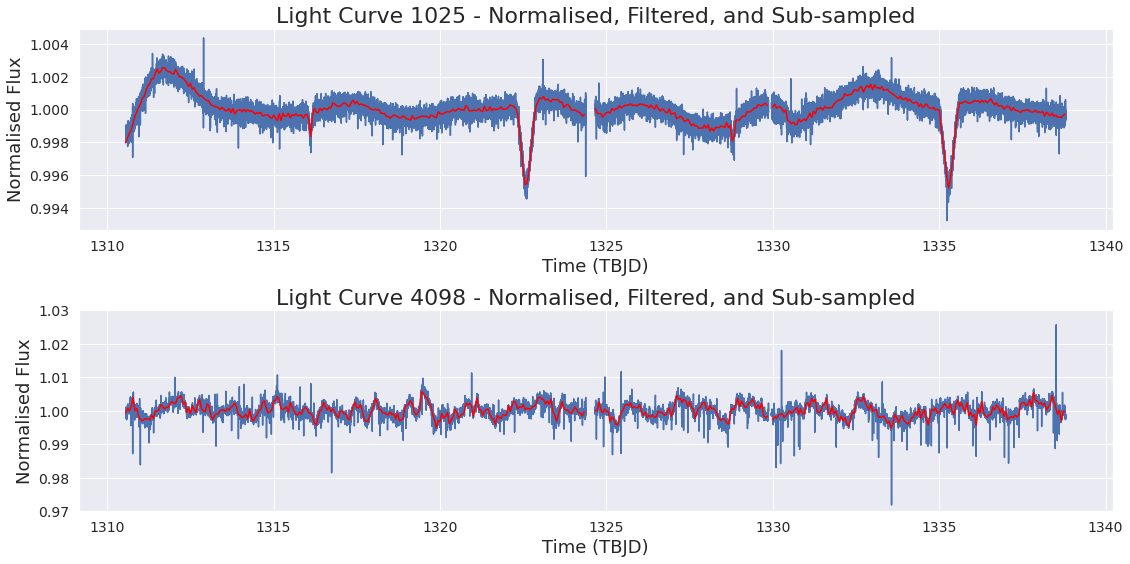

In [11]:
plt.rcParams["figure.figsize"] = (16,8)

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.35)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1.plot(x1,y1_norm)
ax1.plot(x1_sub,y1_sub,'#ff0000')
ax1.set_xlabel(xlab1, fontsize=18)
ax1.set_ylabel("Normalised Flux", fontsize=18)
ax1.set_title(f"Light Curve {n1} - Normalised, Filtered, and Sub-sampled", fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(x2,y2_norm)
ax2.plot(x2_sub,y2_sub,'#ff0000')
ax2.set_xlabel(xlab2, fontsize=18)
ax2.set_ylabel("Normalised Flux", fontsize=18)
ax2.set_title(f"Light Curve {n2} - Normalised, Filtered, and Sub-sampled", fontsize=22)

ax2.set_ylim([0.97,1.03])

ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("./img/lc-scales-new-subsampled-overlay.png")
plt.show()

## FFT / PowerSpectrum of the 2 curves

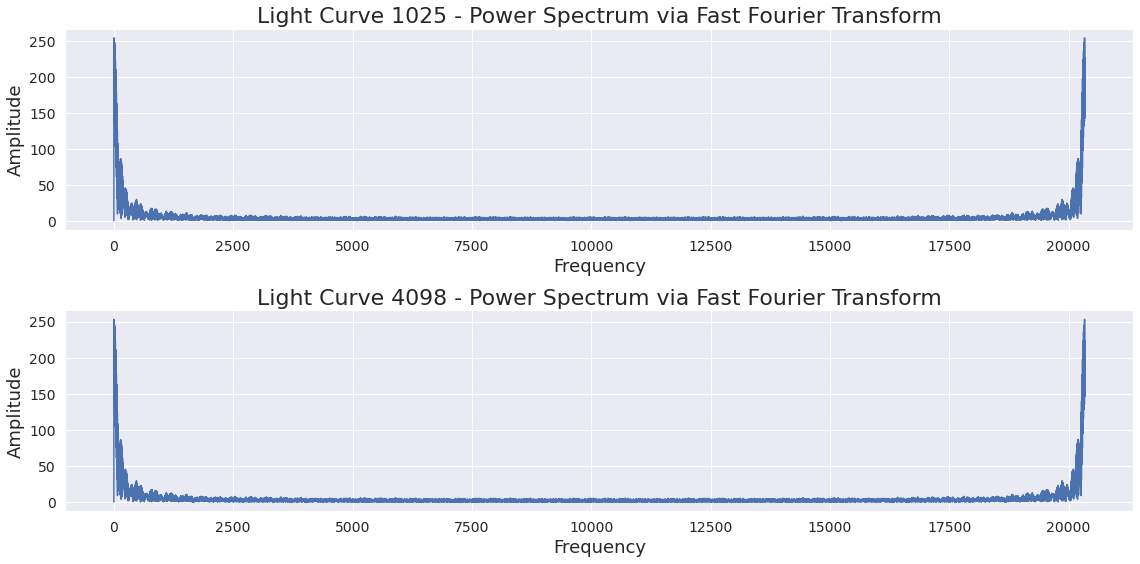

In [12]:
plt.rcParams["figure.figsize"] = (16,8)
fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.35)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

y1_fft = FTTMyData(y1_norm)
y2_fft = FTTMyData(y2_norm)

xlab_fft = "Frequency"
ylab_fft = "Amplitude"

ax1.plot(y1_fft)
ax1.set_xlabel(xlab_fft, fontsize=18)
ax1.set_ylabel(ylab_fft, fontsize=18)
ax1.set_title(f"Light Curve {n1} - Power Spectrum via Fast Fourier Transform", fontsize=22)

ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(y2_fft)
ax2.set_xlabel(xlab_fft, fontsize=18)
ax2.set_ylabel(ylab_fft, fontsize=18)
ax2.set_title(f"Light Curve {n2} - Power Spectrum via Fast Fourier Transform", fontsize=22)

#ax2.set_ylim([0.97,1.03])

ax2.tick_params(axis='both', which='major', labelsize=14)

xlims=[-100,2500]

#ax1.set_xlim(xlims)
#ax2.set_xlim(xlims)

plt.tight_layout()
plt.savefig("./img/lc-scales-new-powspec-a.png")
plt.show()

## More Detailed Look at FFT/PowerSpec

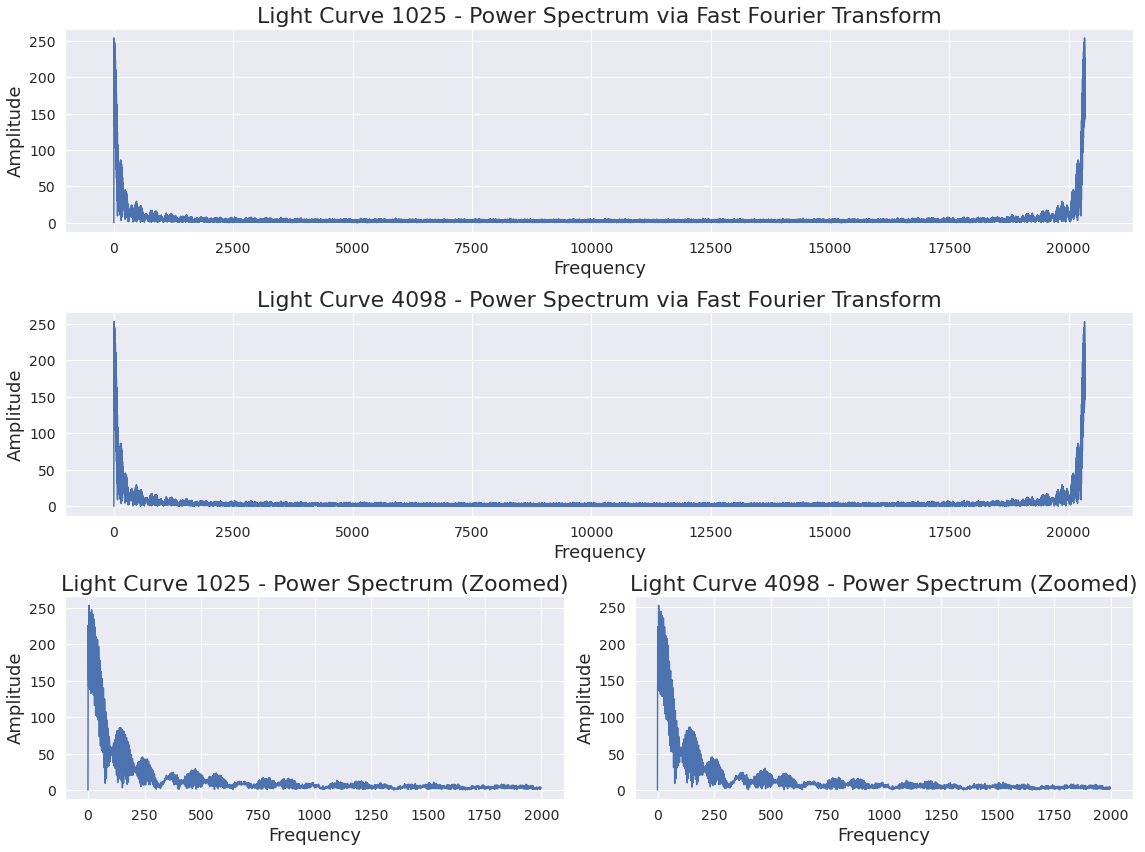

In [13]:
plt.rcParams["figure.figsize"] = (16,12)

fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(3, 2)

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(y1_fft)
ax1.set_xlabel(xlab_fft, fontsize=18)
ax1.set_ylabel(ylab_fft, fontsize=18)
ax1.set_title(f"Light Curve {n1} - Power Spectrum via Fast Fourier Transform", fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = fig.add_subplot(gs[1, :])
ax2.plot(y2_fft)
ax2.set_xlabel(xlab_fft, fontsize=18)
ax2.set_ylabel(ylab_fft, fontsize=18)
ax2.set_title(f"Light Curve {n2} - Power Spectrum via Fast Fourier Transform", fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax3 = fig.add_subplot(gs[2, 0])
ax3.plot(y1_fft[:2000])
ax3.set_xlabel(xlab_fft, fontsize=18)
ax3.set_ylabel(ylab_fft, fontsize=18)
ax3.set_title(f"Light Curve {n1} - Power Spectrum (Zoomed)", fontsize=22)
ax3.tick_params(axis='both', which='major', labelsize=14)

ax4 = fig.add_subplot(gs[2, 1])
ax4.plot(y2_fft[:2000])
ax4.set_xlabel(xlab_fft, fontsize=18)
ax4.set_ylabel(ylab_fft, fontsize=18)
ax4.set_title(f"Light Curve {n2} - Power Spectrum (Zoomed)", fontsize=22)
ax4.tick_params(axis='both', which='major', labelsize=14)


fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.tight_layout()
plt.savefig("./img/lc-scales-new-powspec-b.png")
plt.show()

## Comparison between FFT on Normalised and Raw Curves

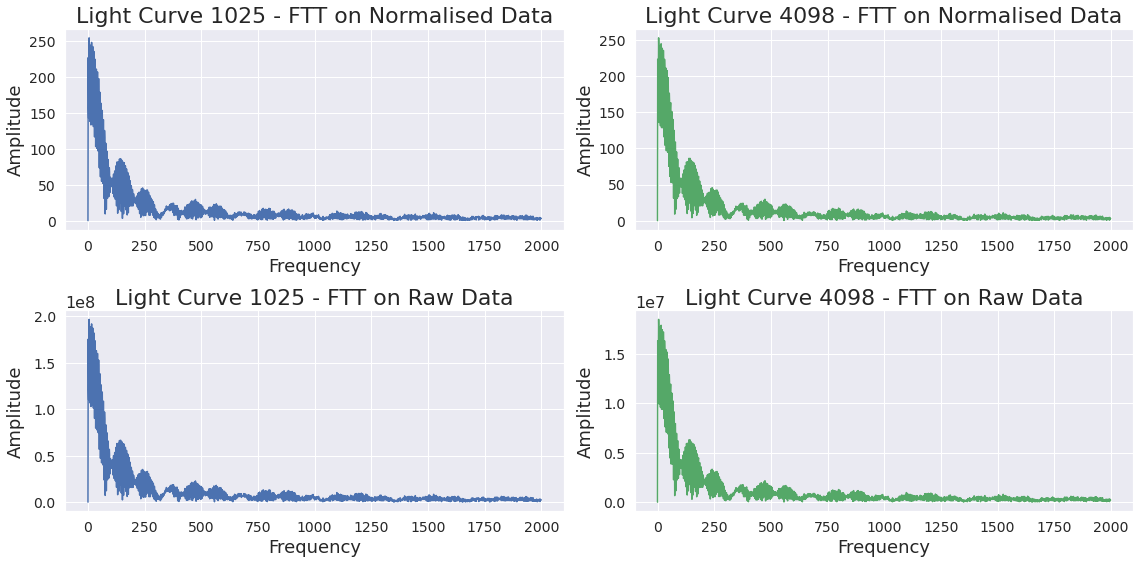

In [14]:
plt.rcParams["figure.figsize"] = (16,8)

y1a_fft = FTTMyData(y1)
y2a_fft = FTTMyData(y2)

fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(y1_fft[:2000])
ax1.set_xlabel(xlab_fft, fontsize=18)
ax1.set_ylabel(ylab_fft, fontsize=18)
ax1.set_title(f"Light Curve {n1} - FTT on Normalised Data", fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(y2_fft[:2000], 'g')
ax2.set_xlabel(xlab_fft, fontsize=18)
ax2.set_ylabel(ylab_fft, fontsize=18)
ax2.set_title(f"Light Curve {n2} - FTT on Normalised Data", fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(y1a_fft[:2000])
ax3.set_xlabel(xlab_fft, fontsize=18)
ax3.set_ylabel(ylab_fft, fontsize=18)
ax3.set_title(f"Light Curve {n1} - FTT on Raw Data", fontsize=22)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.yaxis.offsetText.set_fontsize(16)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(y2a_fft[:2000], 'g')
ax4.set_xlabel(xlab_fft, fontsize=18)
ax4.set_ylabel(ylab_fft, fontsize=18)
ax4.set_title(f"Light Curve {n2} - FTT on Raw Data", fontsize=22)
ax4.tick_params(axis='both', which='major', labelsize=14)
ax4.yaxis.offsetText.set_fontsize(16)

fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.tight_layout()
plt.savefig("./img/lc-scales-new-powspec-compare.png")
plt.show()

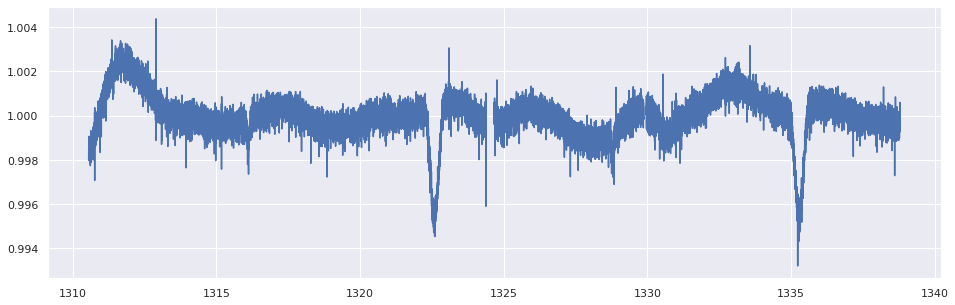

In [338]:
plt.rcParams["figure.figsize"] = (16,5)

plt.plot(x1,y1)

Working Out The Average (and std dev?) of the max amplitudes of normalised data

In [334]:
def WorkoutMax(fluxes):
    
    tmparr = []
    
    for f in fluxes:
        N = NormalSingle(f)
        F = FTTMyData(N)
        M = max(F)
        tmparr.append(M)
        
    return (tmparr)

In [339]:
TRUENOO = np.load("True_NOO_fluxes.npy")

In [313]:
maxFFTlist = WorkoutMax(TRUENOO)

In [336]:
import statistics

MEAN   = statistics.mean(maxFFTlist)
STDDEV = statistics.stdev(maxFFTlist)

MEAN,STDDEV

(308.32190211063767, 1561.530705630412)

In [319]:
np.where(maxFFTlist == max(maxFFTlist))

(array([5994]),)

In [323]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

Q = reject_outliers(np.asarray(maxFFTlist))

In [324]:
Q

array([253.73907948, 258.71017694, 250.81553504, ..., 251.21250113,
       259.75072071, 253.95271761])

In [326]:
max(Q),min(Q),statistics.mean(Q),statistics.stdev(Q)

(263.4113582904062, 247.25838360921767, 254.12095590403757, 3.2301529634359794)

In [328]:
len(TRUENOO[0]), len(TRUENOO[0][::40])

(20338, 509)

In [15]:
xTime = np.load("X_TIME_LIST.npy")

In [16]:
xTime

array([1310.55216337, 1310.55355222, 1310.55494108, ..., 1338.79474641,
       1338.79613527, 1338.79752413])

In [135]:
dt = (xTime[1]-xTime[0])
dt # IN DAYS

0.0013888595594835351

In [136]:
x1, len(x1) / tTotal

(array([1310.55521196, 1310.55660082, 1310.55798967, ..., 1338.7974039 ,
        1338.79879272, 1338.80018155]),
 0.008407606448945846)

In [144]:
fft_freq_axis_array = np.fft.fftfreq(len(y1_fft), dt)

In [145]:
y1_fft_sub = FTTMyData(y1_sub)
y2_fft_sub = FTTMyData(y2_sub)

fft_freq_axis_array_sub = np.fft.fftfreq(len(y1_fft_sub), dt*40)

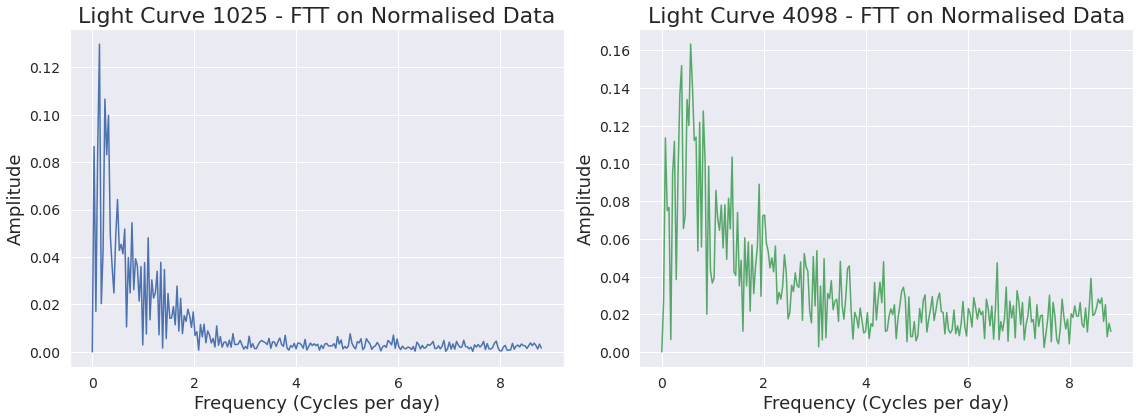

In [146]:
plt.rcParams["figure.figsize"] = (16,6)

y1a_fft = FTTMyData(y1)
y2a_fft = FTTMyData(y2)

fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(1, 2)

xlab_fft = "Frequency (Cycles per day)"

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(fft_freq_axis_array_sub[:250], y1_fft_sub[:250])
ax1.set_xlabel(xlab_fft, fontsize=18)
ax1.set_ylabel(ylab_fft, fontsize=18)
ax1.set_title(f"Light Curve {n1} - FTT on Normalised Data", fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(fft_freq_axis_array_sub[:250], y2_fft_sub[:250], 'g')
ax2.set_xlabel(xlab_fft, fontsize=18)
ax2.set_ylabel(ylab_fft, fontsize=18)
ax2.set_title(f"Light Curve {n2} - FTT on Normalised Data", fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=14)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.xlim

plt.tight_layout()
#plt.savefig("./img/lc-scales-new-powspec-compare.png")
plt.show()

(0.0, 20.0)

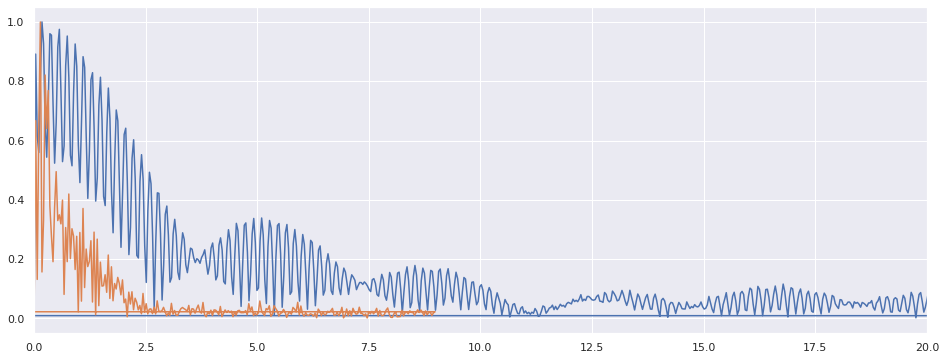

In [147]:
plt.plot(fft_freq_axis_array, (y1_fft/max(y1_fft)))
plt.plot(fft_freq_axis_array_sub, (y1_fft_sub/max(y1_fft_sub)))
plt.xlim([0,20])

These are apparently "not the same curve" and I can clearly see that the two FFT spectrums do appear very different, but I do not know why.

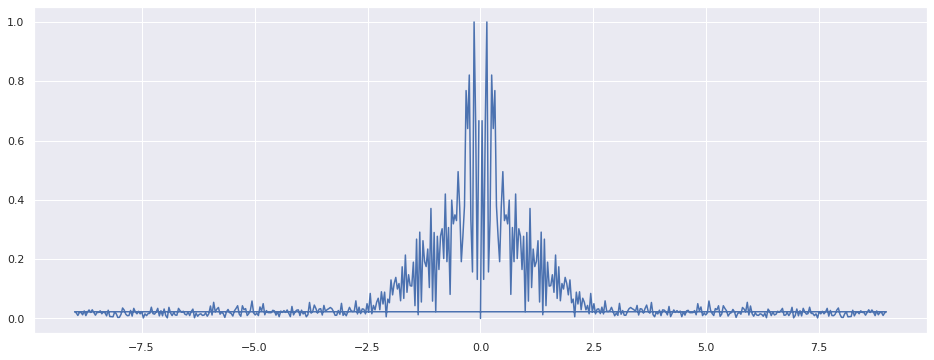

In [151]:
plt.plot(fft_freq_axis_array_sub, (y1_fft_sub/max(y1_fft_sub)))

### Making sure I am using the correct base data (normalised original curve, and the norm/filter/subsampled curve)

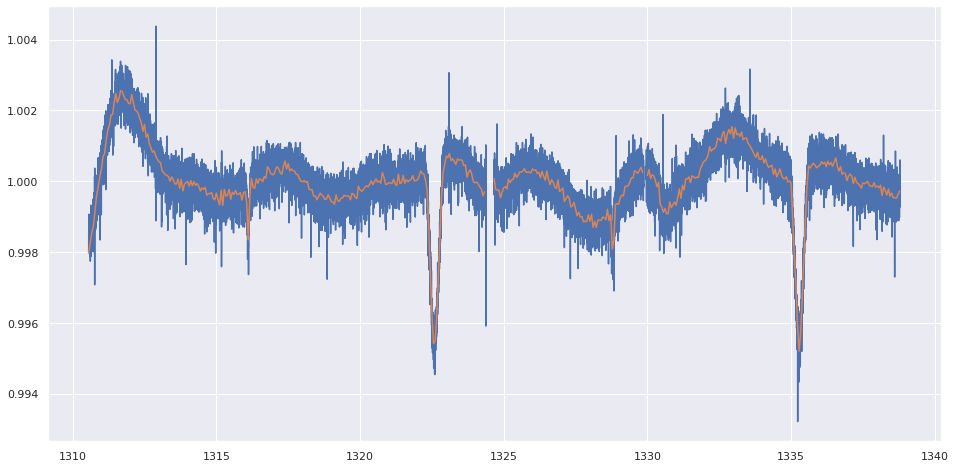

In [129]:
plt.plot(x1,y1_norm)
plt.plot(x1_sub,y1_sub)

(0.0, 20.0)

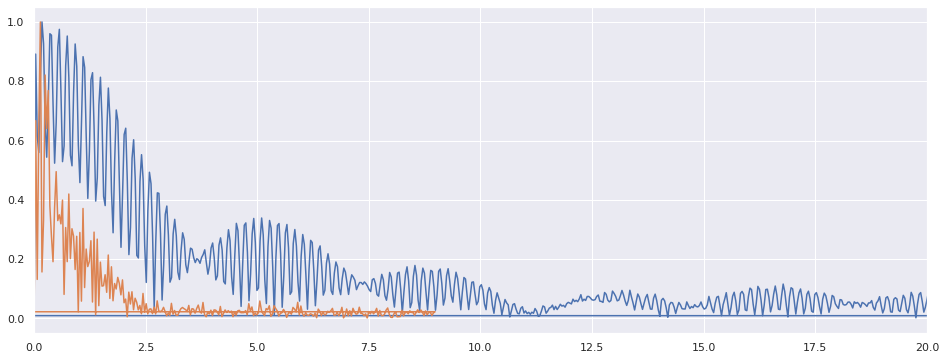

In [160]:
# (1) Generate Data
Ynorm_fft = np.abs(np.fft.fft(y1_norm - np.mean(y1_norm)))
Ysubs_fft = np.abs(np.fft.fft(y1_sub - np.mean(y1_sub)))

# (2) Normalise (div by max val)
Ynorm_fft = Ynorm_fft / max(Ynorm_fft)
Ysubs_fft = Ysubs_fft / max(Ysubs_fft)

# (3) Make x-axes // freq-axes
Xnorm_fft = np.fft.fftfreq(len(Ynorm_fft),dt)
Xsubs_fft = np.fft.fftfreq(len(Ysubs_fft),dt*40)   # <----- dt is 1/40 th of the original because we are subsampling every 40th datapoint

# (4) Plot Together
plt.plot(Xnorm_fft, Ynorm_fft)
plt.plot(Xsubs_fft, Ysubs_fft)
plt.xlim([0,20])